In [1]:
%load_ext autoreload
%autoreload 2

from pcurve import PrincipalCurve
import numpy as np
from matplotlib import pyplot as plt

(1000, 2)


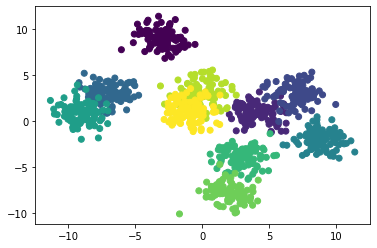

In [3]:
load=True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10 # cluster labels
if num_branches == 2:
    filename = 'fakedata-2branch.npy'
    start_node = 5
else:
    filename = 'fakedata-1branch.npy'
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data['cluster_labels']
    data = data['data'].numpy()
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = torch.randint(20, torch.Size([2])) - 10
        print(offset.shape)

        data.append(offset + torch.randn(torch.Size([num_cells//K, num_dims_reduced])))
        cluster_labels[k*cells:(k+1)*cells] = k
    data = torch.cat(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

cluster_labels_onehot = np.zeros((cluster_labels.shape[0], cluster_labels.max()+1))
cluster_labels_onehot[np.arange(cluster_labels.shape[0]), cluster_labels] = 1

print(data.shape)

In [2]:
from project_to_curve_converted import project_to_curve

t = np.random.uniform(-1, 1, 100)
x = np.stack([t, t**2], axis=1) + np.random.normal(0, 0.05, (100, 2))
x[:, 0] += 1
# x = data
plt.scatter(x[:, 0], x[:, 1], s=5, label='data')
cluster_centres = np.stack([data[cluster_labels == k].mean(axis=0) for k in range(10)])
s = np.array([[0., 1., 2.], [1., 0., 1.]]).T
# s = cluster_centres
plt.scatter(s[:, 0], s[:, 1], label='curve points')

# Try original
curve = PrincipalCurve(k=3)
curve.fit(x, p=s, max_iter=1)
# plt.scatter(curve.points[:, 0], curve.points[:, 1], label='curve.points')
p_interp = curve.points_interp
# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='curve.p_interp')
from scipy.interpolate import interp1d
p_interps = list()
# for j in range(p_interp.shape[1]):
#     interp = interp1d(curve.pseudotimes_interp, x[:, j], kind='cubic')
#     p_interps.append(interp(curve.pseudotimes_interp[curve.order]))
# p_interp = np.stack(p_interps, axis=1)
# plt.plot(p_interp[:, 0], p_interp[:, 1])

# curve, dist_ind, dist = curve._project_to_curve(x, s)
# p_interp = curve.points_interp
# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='original p_interp', s=10, alpha=0.5, color='red')

# Try new
curve, dist_ind, dist = curve.project_to_curve(x, s)
pseudotime_interp = curve.pseudotimes_interp
print('s_interp', pseudotime_interp)
p_interp = curve.points_interp
# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='p_interp')
# plt.plot(curve.points[:, 0], curve.points[:, 1])
plt.scatter(p_interp[:, 0], p_interp[:, 1], label='new p_interp', s=10, alpha=0.5, color='black')

s_interp, p_interp, order, dist_ind, dist = project_to_curve(x, s)
plt.scatter(p_interp[:, 0], p_interp[:, 1], label='neww p_interp', s=10, alpha=0.5, color='red')

print('s_interp 2', s_interp)
for i in range(10):
    path_from = (x[i][0], p_interp[i][0])
    path_to = (x[i][1], p_interp[i][1])
    plt.plot(path_from, path_to, c='black', alpha=pseudotime_interp[i])

plt.legend()


NameError: name 'np' is not defined

In [9]:
print(dist_ind.shape)

(100,)


In [36]:
diff = points[1:] - points[:-1]  # first difference
# denominator = np.power(np.linalg.norm(diff, axis=1), 2)
length = np.square(diff).sum(axis=1)
for i in range(X.shape[0]): # for each point
    z = X[i, :]  # z is the vector of the dimensions for the point
    numerator = diff.T * np.einsum('ij,ij->i', z - points[:-1], diff)  # multiply and sum along second axis
    seg_proj = (numerator / length).T  # compute parallel component
    proj_dist = (z - points[:-1]) - seg_proj  # compute perpendicular component
    dist_endpts = np.minimum(np.linalg.norm(z - points[0:-1], axis=1), np.linalg.norm(z - points[1:], axis = 1))
    dist_seg = np.maximum(np.linalg.norm(proj_dist, axis=1), dist_endpts)

    idx_min = np.argmin(dist_seg)
    q = seg_proj[idx_min]
    t_diff = pseudotimes[idx_min + 1] - pseudotimes[idx_min]
    x_diff = points[idx_min + 1, :] - points[idx_min, :]
    s_interp[i] = (np.linalg.norm(q) / np.linalg.norm(x_diff)) * t_diff + pseudotimes[idx_min]
    p_interp[i] = (s_interp[i] - pseudotimes[idx_min]) * x_diff + points[idx_min, :]

    n_test = points[:-1] + seg_proj
    w = np.square(n_test - z).sum(axis=1)
    print(w)
    p_interp[i] =
    d_sq.append(np.linalg.norm(proj_dist[idx_min])**2)

SyntaxError: invalid syntax (<ipython-input-36-698b7ab0ffc3>, line 22)

(100, 2) (3, 2)
[0.         0.00786714 0.19695697 0.20298347 0.21429991 0.23966355
 0.34237537 0.344851   0.37944775 0.379934   0.39943421 0.44576021
 0.4541957  0.46385593 0.48966939 0.54273493 0.61947919 0.73658623
 0.75214536 0.78507071 0.8302279  0.84664813 0.89489194 0.90956516
 0.9187851  0.93804083 0.99951155 1.04932697 1.06066471 1.07506093
 1.09732363 1.1040448  1.13730331 1.143096   1.15701422 1.16522381
 1.17268355 1.17315769 1.19421606 1.22596771 1.26733518 1.27960205
 1.28881318 1.31299234 1.31425832 1.33563042 1.35377708 1.38223722
 1.39525234 1.42512274 1.46269906 1.46630396 1.46995023 1.48952748
 1.49356433 1.50132075 1.5170697  1.53119957 1.54255644 1.57837435
 1.5871016  1.60757761 1.61488242 1.61722448 1.62078875 1.638575
 1.64550099 1.67216432 1.69948773 1.70152239 1.72330355 1.77278782
 1.85169645 1.88003938 1.94567499 1.97300881 1.98232198 2.01220532
 2.12051651 2.13667573 2.15779592 2.16341964 2.20982512 2.21568264
 2.22207531 2.25564729 2.27860846 2.28705646 2.2

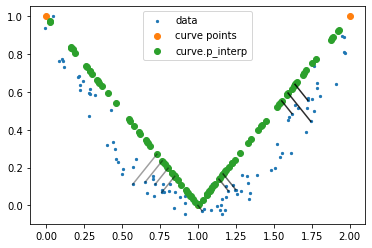

In [25]:
t = np.random.uniform(-1, 1, 100)
x = np.stack([t, t**2], axis=1) + np.random.normal(0, 0.05, (100, 2))
x[:, 0] += 1
plt.scatter(x[:, 0], x[:, 1], s=5, label='data')
s = np.array([[0., 1, 2], [1, 0, 1]]).T
print(x.shape, s.shape)
plt.scatter(s[:, 0], s[:, 1], label='curve points')
curve = PrincipalCurve(k=3)
curve.project_to_curve(x, points=s)
# curve.fit(x, initial_points=s, max_iter=1)
p_interp = curve.points_interp
s_interp = curve.pseudotimes_interp
plt.scatter(p_interp[:, 0], p_interp[:, 1], label='curve.p_interp')
# plt.plot(curve.points[:, 0], curve.points[:, 1], label='curve.points')

# plt.scatter(p_interp[:, 0], p_interp[:, 1], label='p_interp')
# plt.plot(curve.points[:, 0], curve.points[:, 1])
alpha = s_interp

uniq, ind = np.unique(s_interp, return_index=True)
print(uniq, ind)
print(s_interp.shape, )
alpha = (alpha - alpha.min()) / (alpha.max() - alpha.min())
for i in range(10):
    path_from = (x[i][0], p_interp[i][0])
    path_to = (x[i][1], p_interp[i][1])
    plt.plot(path_from, path_to, c='black', alpha=alpha[i])

plt.legend()

In [6]:
from project_to_curve_converted import project_to_curve as c_project_to_curve
c_project_to_curve(x, s)
